# Model Dependencies

In [11]:
pip install torch datasets pandas numpy tqdm scikit-learn tokenizers

Note: you may need to restart the kernel to use updated packages.


In [24]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import math
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [25]:
# Disable tokenizer parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [26]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Pre-processing

In [28]:
# Load dataset
df = pd.read_csv("cholito_bengali_human_ai_dataset.csv")
label_map = {"human": 0, "ai": 1}
df["label"] = df["label"].map(label_map)
texts = df["text"].tolist()
labels = df["label"].tolist()
print(f"Label counts: {pd.Series(labels).value_counts().to_dict()}")

Label counts: {0: 9500, 1: 9500}


In [29]:
# Data Splitting
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)
print(f"Train label counts: {pd.Series(train_labels).value_counts().to_dict()}")
print(f"Validation label counts: {pd.Series(val_labels).value_counts().to_dict()}")
print(f"Test label counts: {pd.Series(test_labels).value_counts().to_dict()}")

Train label counts: {1: 7600, 0: 7600}
Validation label counts: {1: 950, 0: 950}
Test label counts: {1: 950, 0: 950}


# Custom Tokenizer

In [36]:
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()
trainer = WordPieceTrainer(vocab_size=30000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
tokenizer.train_from_iterator(train_texts, trainer)
tokenizer.save("bengali_wordpiece_tokenizer.json")

In [37]:
# Tokenize
def tokenize_texts(texts, tokenizer, max_length=128):
    encodings = tokenizer.encode_batch(texts)
    input_ids = []
    attention_masks = []
    for enc in encodings:
        ids = enc.ids[:max_length] if len(enc.ids) > max_length else enc.ids + [0] * (max_length - len(enc.ids))
        mask = [1] * len(enc.ids[:max_length]) + [0] * (max_length - len(enc.ids[:max_length]))
        input_ids.append(ids)
        attention_masks.append(mask)
    return {
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "attention_mask": torch.tensor(attention_masks, dtype=torch.long)
    }
train_encodings = tokenize_texts(train_texts, tokenizer)
val_encodings = tokenize_texts(val_texts, tokenizer)
test_encodings = tokenize_texts(test_texts, tokenizer)

In [38]:
# Dataset
class BengaliTextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = BengaliTextDataset(train_encodings, train_labels)
val_dataset = BengaliTextDataset(val_encodings, val_labels)
test_dataset = BengaliTextDataset(test_encodings, test_labels)

In [39]:
# Create Dataloader
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Build the Model

In [40]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class CustomTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_encoder_layers=4, dim_feedforward=512, num_classes=2):
        super(CustomTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.fc = nn.Linear(d_model, num_classes)
        self.d_model = d_model

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        if attention_mask is not None:
            # Convert attention mask: 1 (valid token) -> False, 0 (padding) -> True
            key_padding_mask = (attention_mask == 0)
            x = self.transformer_encoder(x, src_key_padding_mask=key_padding_mask)
        else:
            x = self.transformer_encoder(x)
        x = x[:, 0, :]  # Use [CLS] token representation
        return self.fc(x)

# Initialize model
vocab_size = tokenizer.get_vocab_size()
model = CustomTransformer(vocab_size=vocab_size)
model.to(device)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Set up Training

In [41]:
# Training and evaluation functions
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    progress_bar = tqdm(data_loader, desc="Training", unit="batch")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({"loss": loss.item()})
    return total_loss / len(data_loader)

def evaluate(model, data_loader, device, desc="Evaluating"):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    progress_bar = tqdm(data_loader, desc=desc, unit="batch")
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            progress_bar.set_postfix({"loss": loss.item()})

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = np.mean(predictions == true_labels)
    cm = np.zeros((2, 2), dtype=int)
    for t, p in zip(true_labels, predictions):
        cm[t, p] += 1
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "loss": total_loss / len(data_loader),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm.tolist()
    }

# Train the Model

In [44]:
# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    val_metrics = evaluate(model, val_loader, device, desc="Validating")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Metrics: Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}, "
          f"Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1']:.4f}")
    print(f"Confusion Matrix:\n{np.array(val_metrics['confusion_matrix'])}")



Epoch 1/10


Training: 100%|█████████████████| 950/950 [06:05<00:00,  2.60batch/s, loss=0.73]
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(
Validating: 100%|██████████████| 119/119 [00:09<00:00, 11.96batch/s, loss=0.909]


Train Loss: 0.6927
Validation Metrics: Loss: 0.6939, Accuracy: 0.5563, Precision: 0.5554, Recall: 0.5642, F1: 0.5598
Confusion Matrix:
[[521 429]
 [414 536]]

Epoch 2/10


Validating: 100%|██████████████| 119/119 [00:10<00:00, 11.17batch/s, loss=0.909]


Train Loss: 0.6910
Validation Metrics: Loss: 0.6939, Accuracy: 0.5563, Precision: 0.5554, Recall: 0.5642, F1: 0.5598
Confusion Matrix:
[[521 429]
 [414 536]]

Epoch 3/10


Validating: 100%|██████████████| 119/119 [00:10<00:00, 11.29batch/s, loss=0.909]


Train Loss: 0.6917
Validation Metrics: Loss: 0.6939, Accuracy: 0.5563, Precision: 0.5554, Recall: 0.5642, F1: 0.5598
Confusion Matrix:
[[521 429]
 [414 536]]

Epoch 4/10


Validating: 100%|██████████████| 119/119 [00:05<00:00, 20.06batch/s, loss=0.909]


Train Loss: 0.6939
Validation Metrics: Loss: 0.6939, Accuracy: 0.5563, Precision: 0.5554, Recall: 0.5642, F1: 0.5598
Confusion Matrix:
[[521 429]
 [414 536]]

Epoch 5/10


Validating: 100%|██████████████| 119/119 [00:06<00:00, 17.41batch/s, loss=0.909]


Train Loss: 0.6937
Validation Metrics: Loss: 0.6939, Accuracy: 0.5563, Precision: 0.5554, Recall: 0.5642, F1: 0.5598
Confusion Matrix:
[[521 429]
 [414 536]]

Epoch 6/10


Validating: 100%|██████████████| 119/119 [00:06<00:00, 18.17batch/s, loss=0.909]


Train Loss: 0.6944
Validation Metrics: Loss: 0.6939, Accuracy: 0.5563, Precision: 0.5554, Recall: 0.5642, F1: 0.5598
Confusion Matrix:
[[521 429]
 [414 536]]

Epoch 7/10


Validating: 100%|██████████████| 119/119 [00:06<00:00, 18.08batch/s, loss=0.909]


Train Loss: 0.6925
Validation Metrics: Loss: 0.6939, Accuracy: 0.5563, Precision: 0.5554, Recall: 0.5642, F1: 0.5598
Confusion Matrix:
[[521 429]
 [414 536]]

Epoch 8/10


Validating: 100%|██████████████| 119/119 [00:06<00:00, 18.18batch/s, loss=0.909]


Train Loss: 0.6940
Validation Metrics: Loss: 0.6939, Accuracy: 0.5563, Precision: 0.5554, Recall: 0.5642, F1: 0.5598
Confusion Matrix:
[[521 429]
 [414 536]]

Epoch 9/10


Validating: 100%|██████████████| 119/119 [00:06<00:00, 19.22batch/s, loss=0.909]


Train Loss: 0.6929
Validation Metrics: Loss: 0.6939, Accuracy: 0.5563, Precision: 0.5554, Recall: 0.5642, F1: 0.5598
Confusion Matrix:
[[521 429]
 [414 536]]

Epoch 10/10


Validating: 100%|██████████████| 119/119 [00:07<00:00, 15.33batch/s, loss=0.909]

Train Loss: 0.6937
Validation Metrics: Loss: 0.6939, Accuracy: 0.5563, Precision: 0.5554, Recall: 0.5642, F1: 0.5598
Confusion Matrix:
[[521 429]
 [414 536]]


In [45]:
# Test evaluation
test_metrics = evaluate(model, test_loader, device, desc="Testing")
print(f"\nTest Metrics: Loss: {test_metrics['loss']:.4f}, Accuracy: {test_metrics['accuracy']:.4f}, "
      f"Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1']:.4f}")
print(f"Confusion Matrix:\n{np.array(test_metrics['confusion_matrix'])}")

Testing: 100%|█████████████████| 119/119 [00:07<00:00, 16.00batch/s, loss=0.611]


Test Metrics: Loss: 0.7027, Accuracy: 0.5479, Precision: 0.5462, Recall: 0.5663, F1: 0.5561
Confusion Matrix:
[[503 447]
 [412 538]]


In [47]:
# Save model
torch.save(model.state_dict(), "bengali_custom_transformer.pt")
tokenizer.save("bengali_wordpiece_tokenizer.json")
print("Model saved to 'bengali_custom_transformer.pt' and tokenizer saved to 'bengali_wordpiece_tokenizer.json'")

Model saved to 'bengali_custom_transformer.pt' and tokenizer saved to 'bengali_wordpiece_tokenizer.json'


# Another One

In [1]:
import os
import math
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tokenizers import ByteLevelBPETokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 32
max_length = 128
num_epochs = 20
learning_rate = 3e-4

Using device: cuda


In [3]:
df = pd.read_csv("cholito_bengali_human_ai_dataset.csv")
df = df[df['label'].isin(['human', 'ai'])]  # Filter unwanted labels
label_map = {"human": 0, "ai": 1}
df["label"] = df["label"].map(label_map)
texts, labels = df["text"].tolist(), df["label"].tolist()

train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


# Tokenizer

In [4]:
if not os.path.exists("bengali_tokenizer"):
    os.makedirs("bengali_tokenizer")  # Ensure the directory exists
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train_from_iterator(train_texts, vocab_size=30000, min_frequency=2, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
    tokenizer.save_model("bengali_tokenizer")
else:
    tokenizer = ByteLevelBPETokenizer("bengali_tokenizer/vocab.json", "bengali_tokenizer/merges.txt")

def encode_batch(texts):
    encodings = tokenizer.encode_batch(texts)
    input_ids, attention_masks = [], []
    for e in encodings:
        ids = e.ids[:max_length] + [0] * (max_length - len(e.ids)) if len(e.ids) < max_length else e.ids[:max_length]
        mask = [1] * min(len(e.ids), max_length) + [0] * (max_length - len(e.ids))
        input_ids.append(ids)
        attention_masks.append(mask)
    return torch.tensor(input_ids), torch.tensor(attention_masks)

class BengaliTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.input_ids, self.attention_mask = encode_batch(texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

train_dataset = BengaliTextDataset(train_texts, train_labels)
val_dataset = BengaliTextDataset(val_texts, val_labels)
test_dataset = BengaliTextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Custom Class

In [5]:
class CustomTransformer(nn.Module):
    def __init__(self, vocab_size, max_len=128, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.3, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        positions = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
        x = self.embedding(input_ids) + self.position_embedding(positions)
        x = self.encoder(x, src_key_padding_mask=~attention_mask.bool())
        x = self.dropout(x[:, 0])  # Take CLS token representation
        return self.classifier(x)


# Training Setup

In [6]:
vocab_size = tokenizer.get_vocab_size()
model = CustomTransformer(vocab_size=vocab_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# Scheduler (optional warmup + decay)
from transformers import get_cosine_schedule_with_warmup
warmup_steps = 500
total_steps = len(train_loader) * num_epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)


In [7]:
def train_epoch():
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return total_loss / len(loader), accuracy, all_preds, all_labels

# Training

In [8]:
best_val_acc = 0.0
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_epoch()
    val_loss, val_acc, _, _ = evaluate(val_loader)
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save model if it improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_bengali_transformer.pt")
        print("Saved new best model.")

# Test
print("\nFinal Evaluation on Test Set:")
test_loss, test_acc, test_preds, test_labels = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")





Epoch 1/20


Training: 100%|██████████████████████████████████████████████████████████████████████| 475/475 [00:35<00:00, 13.24it/s]
C:\Users\Jim\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(
Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 45.54it/s]


Train Loss: 0.4713, Val Loss: 0.3383, Val Acc: 0.9253
Saved new best model.

Epoch 2/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.63it/s]


Train Loss: 0.3432, Val Loss: 0.3975, Val Acc: 0.9158

Epoch 3/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.15it/s]


Train Loss: 0.3293, Val Loss: 0.3243, Val Acc: 0.9421
Saved new best model.

Epoch 4/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.27it/s]


Train Loss: 0.3263, Val Loss: 0.4588, Val Acc: 0.8684

Epoch 5/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 48.56it/s]


Train Loss: 0.4169, Val Loss: 0.4304, Val Acc: 0.8758

Epoch 6/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.19it/s]


Train Loss: 0.4536, Val Loss: 0.4066, Val Acc: 0.8853

Epoch 7/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.67it/s]


Train Loss: 0.4086, Val Loss: 0.5014, Val Acc: 0.8363

Epoch 8/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.45it/s]


Train Loss: 0.5246, Val Loss: 0.8762, Val Acc: 0.5458

Epoch 9/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.50it/s]


Train Loss: 0.5661, Val Loss: 0.9056, Val Acc: 0.6221

Epoch 10/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.53it/s]


Train Loss: 0.5158, Val Loss: 1.1524, Val Acc: 0.5011

Epoch 11/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.60it/s]


Train Loss: 0.5776, Val Loss: 0.8540, Val Acc: 0.5047

Epoch 12/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 48.95it/s]


Train Loss: 0.5469, Val Loss: 0.5872, Val Acc: 0.7816

Epoch 13/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.44it/s]


Train Loss: 0.4185, Val Loss: 0.4050, Val Acc: 0.8768

Epoch 14/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.45it/s]


Train Loss: 0.3926, Val Loss: 0.4127, Val Acc: 0.8805

Epoch 15/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 48.91it/s]


Train Loss: 0.3578, Val Loss: 0.3850, Val Acc: 0.9047

Epoch 16/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.50it/s]


Train Loss: 0.3383, Val Loss: 0.3790, Val Acc: 0.9079

Epoch 17/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.77it/s]


Train Loss: 0.3280, Val Loss: 0.3750, Val Acc: 0.9032

Epoch 18/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.95it/s]


Train Loss: 0.3218, Val Loss: 0.3500, Val Acc: 0.9158

Epoch 19/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.76it/s]


Train Loss: 0.3173, Val Loss: 0.3541, Val Acc: 0.9168

Epoch 20/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.99it/s]


Train Loss: 0.3155, Val Loss: 0.3537, Val Acc: 0.9158

Final Evaluation on Test Set:


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.76it/s]


Test Loss: 0.3547, Test Accuracy: 0.9116


NameError: name 'confusion_matrix' is not defined

In [10]:
import torch

# Load best model weights
model.load_state_dict(torch.load("best_bengali_transformer.pt"))
model.eval()

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.88it/s]

Test Loss: 0.3359, Test Accuracy: 0.9363


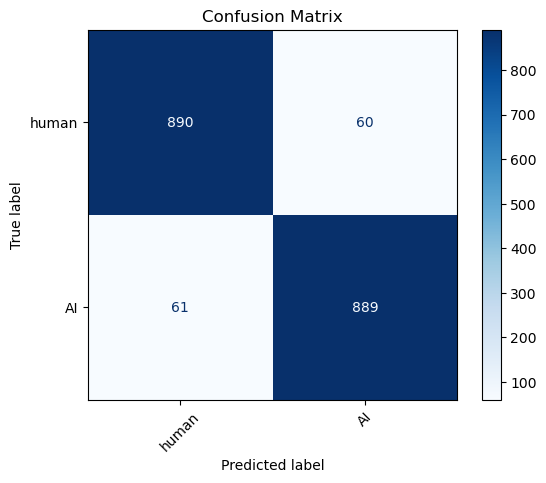

Classification Report:
              precision    recall  f1-score   support

       human     0.9359    0.9368    0.9363       950
          AI     0.9368    0.9358    0.9363       950

    accuracy                         0.9363      1900
   macro avg     0.9363    0.9363    0.9363      1900
weighted avg     0.9363    0.9363    0.9363      1900



In [12]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert predictions and labels to numpy arrays (if not already)
test_preds = test_preds.cpu().numpy() if hasattr(test_preds, "cpu") else test_preds
test_labels = test_labels.cpu().numpy() if hasattr(test_labels, "cpu") else test_labels

# Define class names
class_names = ["human", "AI"]

# Plot confusion matrix with labels
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Print classification report with label names
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))
